In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import csv

import numpy as np

from tqdm import trange
from statistics import mean 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Предобработка документа

In [2]:
# text = pd.read_csv('/kaggle/input/some-topics/inetensive_1.csv')
# print(text.head())

In [3]:
# syntax = ".,?!;:-)(\/#0123456789"
# stopwords = nltk.corpus.stopwords.words("english")

# print(text['text'].size)
# text['edited'] = "sometext"
# for i in trange(text['text'].size):
#     text['edited'][i] = text['text'][i].lower()
#     for j in syntax:
#         text['edited'][i] = text['edited'][i].replace(j, "")
#     text['edited'][i] = text['edited'][i].replace('  ', " ")
    
#     text['edited'][i] = [word for word in text['edited'][i].split(' ') if word not in stopwords]

In [4]:
# text.to_csv("modified.csv", index=False)

# Параметры

In [5]:
# ALL PARAMETERS
number_of_takes = 100
take_rows = 20
CONTEXT_SIZE = 2
EMBEDDING_DIM = 300
BS = 2000
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

text = pd.read_csv('/kaggle/input/some-topics/modified.csv', nrows =1)
columns = text.columns

# Определяем размерность векторного пространства

In [6]:
null_vector = {} # вектор с размерностью алфавита

for fragment in trange(number_of_takes):
    text = pd.read_csv('/kaggle/input/some-topics/modified.csv', skiprows = fragment * take_rows, nrows = take_rows, names=columns)
    for i in range(take_rows):
        text['edited'][i] = text['edited'][i].replace('\'', '').replace('\"', '').replace(']', '').replace('[', '').split(', ')
        for k in set(text['edited'][i]):
            null_vector[k] = 0;

print("Length of our vocabulary: ", len(null_vector))
# print(null_vector)

100%|██████████| 100/100 [00:01<00:00, 88.67it/s]

Length of our vocabulary:  11273


# Функция получение пар контекст/слово в one-hot-vector виде

In [7]:
def get_training_data(from_row, to_row):
    text = pd.read_csv('/kaggle/input/some-topics/modified.csv', skiprows=from_row, nrows=take_rows, names=columns)

    context = [[]]*take_rows
    for i in range(text['text'].size):
        text['edited'][i] = text['edited'][i].replace('\'', '').replace('\"', '').replace(']', '').replace('[', '').split(', ')
        for k in range(CONTEXT_SIZE, len(text['edited'][i]) - CONTEXT_SIZE):
            tup = []
            for c in range(1, CONTEXT_SIZE+1):
                tup.append(text['edited'][i][k-c])
                tup.append(text['edited'][i][k+c])

            context[i].append([tup,text['edited'][i][k]])
    
    vec_context = []
    for i in range(len(context)):
        for j in range(len(context[i])):
            creating = [[], []]
            copy = null_vector.copy()
            copy[context[i][j][1]] = 1
            creating[1] = list(copy.values())

            copy = null_vector.copy()
            copy[context[i][j][0][0]] = 1
            copy[context[i][j][0][1]] = 1
            copy[context[i][j][0][2]] = 1
            copy[context[i][j][0][3]] = 1
            creating[0] = list(copy.values())

            vec_context.append(creating)
    
    return vec_context

# Функция дообучения

In [8]:
def continuous_training(model, optimizer, loss_function, vec_context, BS):
    vec_context = np.array(vec_context)
    total_loss = 0

    num_batches = len(vec_context)//BS

    for i in range(num_batches):
        pairs = vec_context[i*BS:(i+1)*BS]
        context_idxs = torch.tensor(pairs[:,0].astype(int), dtype=torch.float).to(device)

        optimizer.zero_grad()
        log_probs = model(context_idxs)

        # print(log_probs.shape, torch.tensor(pairs[:,1].astype(int), dtype=torch.long).to(device).shape)

        loss = loss_function(log_probs, torch.tensor(pairs[:,1].astype(int), dtype=torch.long).argmax(-1).to(device))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss

# Модель

In [9]:
class CBOWModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModeler, self).__init__()
        self.linear1 = nn.Linear(vocab_size, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, vocab_size)
        
    
    def forward(self, inputs):
        emb = self.linear1(inputs)
        out_s_layer = self.linear2(emb)
        
        # print(out_s_layer.shape)
        log_probs = F.log_softmax(out_s_layer, dim=0)
        return log_probs
    
    
    def predict(self, input, null_vector):
        context_vec = null_vector.copy()
        for word in input:
            context_vec[word] = 1;
        context_vec = list(context_vec.values())
        
        context_tensor = torch.tensor(context_vec, dtype=torch.float).to(device)
        res = self.forward(context_tensor)
        print(res.shape)
        res_arg = torch.argmax(res).item()
        
        return list(null_vector.keys())[res_arg]
    
    
    def write_embedding_to_file(self,filename):
        for i in self.embeddings.parameters():
            weights = i.cpu().data.numpy()
        np.save(filename,weights)
        
    
    def write_linear_to_file(self,filename):
        for i in self.linear2.parameters():
            weights = i.cpu().data.numpy()
        np.save(filename,weights)

        
model = CBOWModeler(len(null_vector), EMBEDDING_DIM)
optimizer = optim.SGD(model.parameters(), lr=10**(-6))

model = model.to(device)
loss_function = nn.NLLLoss()

# Обучение на текстах по кускам

In [10]:
for ep in trange(epochs):
    for i in range(number_of_takes):
        vec_context = get_training_data(i*take_rows, (i+1)*take_rows)
        total_loss = continuous_training(model, optimizer, loss_function, vec_context, BS)
    if ep % 5 == 0:
        print(total_loss)

 10%|█         | 1/10 [54:53<8:14:02, 3293.63s/it]

30.40539789199829


 60%|██████    | 6/10 [5:31:09<3:41:05, 3316.39s/it]

30.405396461486816


100%|██████████| 10/10 [9:10:13<00:00, 3301.40s/it]


# Сохраняем модель 

In [11]:
torch.save(model.state_dict(), 'model')

with open('alphabet.csv', 'w') as f:
    w = csv.DictWriter(f, null_vector.keys())
    w.writeheader()
    w.writerow(null_vector)

# Загружаем, если необходимо

In [12]:
# null_vector = pd.read_csv('/kaggle/input/trashh/alphabet.csv').to_dict(orient='records')[0]
# # null_vector

# model = CBOWModeler(len(null_vector), EMBEDDING_DIM)
# model.load_state_dict(torch.load('/kaggle/input/trashh/model'))
# model = model.to(device)

# Тестируем

In [13]:
# test 1
# inputs = ['black','bears','meat', 'strong']
# res: southeastern

# test 2
# inputs = ['company','need','successful', 'product']
# res: estimates

# test 3 on prev version
# ...black huge _ eat black...
# inputs = ['black','huge','eat', 'black']
# res: jobless

# test 3
inputs = ['news','paper','good', 'news']
# res: remember

# test 4
# inputs = ['young','boy','good', 'job']
# res: invoices

# test 5
# inputs = ['senior','developer','good', 'job']
# res: creates

# test 6
# inputs = ['senior','developer','work', 'program']
# res: creates


pred = model.predict(inputs, null_vector)
print(pred)

torch.Size([11273])
cubans


# Параметры обученной модели

In [14]:
emb_matrix = [i for i in model.linear1.parameters()][0]

emb_matrix = emb_matrix.cpu().detach().numpy()
emb_matrix

array([[ 3.8425631e-03,  6.9359154e-03,  3.4693410e-03, ...,
        -2.3621013e-03,  7.7132345e-03, -5.5134448e-04],
       [ 8.8193957e-03,  6.9997855e-03, -6.5015204e-04, ...,
         9.3350057e-03,  2.3919400e-03, -3.0059588e-05],
       [ 8.6264089e-03, -6.5895957e-03, -5.2267215e-03, ...,
        -6.7805112e-03, -1.2019993e-03,  8.0948444e-03],
       ...,
       [ 3.8016418e-03, -3.3048585e-03,  6.6300444e-03, ...,
         2.3945549e-03,  9.3445191e-03, -8.3655566e-03],
       [-8.7305508e-04,  3.0967942e-03, -1.1783080e-03, ...,
         8.9706453e-03, -8.3292508e-03,  2.8613212e-03],
       [-9.0278490e-03, -6.7823101e-03, -5.4993052e-03, ...,
         5.0827982e-03, -4.2067477e-04,  5.9976135e-03]], dtype=float32)

# Высчитываем векторные представления текстов и сохраняем

In [15]:
def word2vec(inp, null_vector, emb_matrix):
    word = null_vector.copy()
    if (inp in word.keys()): word[inp] = 1
    word = np.array(list(word.values()))

    word2vec = np.matmul(emb_matrix, word)
    return word2vec

In [16]:
text = pd.read_csv('/kaggle/input/some-topics/modified.csv', nrows=number_of_takes*take_rows)
with open(f'vectors.csv', 'w', newline='') as f_object:
    writer_object = csv.writer(f_object)
    
    for row in trange(number_of_takes*take_rows):
        count_words = 0
        text2vec = np.array([float(0)]*EMBEDDING_DIM)
        text['edited'][row] = text['edited'][row].replace('\'', '').replace('\"', '').replace(']', '').replace('[', '').split(', ')
        for word in text['edited'][row]:
            count_words += 1
            text2vec = np.add(text2vec, word2vec(word, null_vector, emb_matrix))
        
        text2vec = [i/count_words for i in text2vec]
        
        list_data = list(text2vec)
        list_data.insert(0, row)
        writer_object.writerow(list_data)
    
    f_object.close()

100%|██████████| 2000/2000 [07:51<00:00,  4.24it/s]


# Тестируем

In [17]:
columns_for_vec = [i for i in range(EMBEDDING_DIM)]
# vectors = pd.read_csv(f'/kaggle/input/trashh/vectors.csv', nrows=take_rows*number_of_takes, names=columns_for_vec, header=None)
vectors = pd.read_csv(f'/kaggle/working/vectors.csv', nrows=take_rows*number_of_takes, names=columns_for_vec, header=None)
text = pd.read_csv(f'/kaggle/input/some-topics/modified.csv', nrows=take_rows*number_of_takes)

vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000195,-0.001000,-0.003117,0.003060,0.000833,-0.003156,-0.001058,-0.000885,-0.000161,-0.000170,...,-0.003946,-0.001028,-0.000686,-0.001089,0.000268,-0.001069,0.000915,0.000490,0.001737,-0.000208
1,0.001425,-0.001791,-0.002250,0.000689,-0.000236,-0.000922,0.000034,0.000467,-0.001196,-0.001662,...,-0.001138,0.000296,-0.001003,0.001583,-0.001640,-0.000828,0.001336,0.000558,0.000995,-0.000333
2,0.000416,-0.001263,0.000026,-0.000234,0.002455,-0.000084,-0.000548,0.000672,0.000584,-0.000515,...,-0.000313,-0.000419,0.001627,0.000263,0.001000,0.001881,-0.000501,0.000667,0.000096,-0.000891
3,0.000644,-0.000692,-0.001115,0.000500,0.001839,0.000566,-0.001064,0.000772,-0.001076,-0.000981,...,-0.000131,-0.000556,-0.000920,0.000296,0.000206,-0.000130,-0.000253,0.003255,0.001967,-0.001976
4,0.000232,0.000257,0.001437,-0.001730,0.001435,0.000666,0.000415,-0.001045,0.000475,0.001179,...,0.002133,-0.000916,-0.000177,-0.000981,0.001051,0.002363,-0.001141,-0.000020,0.000541,-0.000086


In [18]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [19]:
X_train, X_test, y_train, y_test = train_test_split(vectors[columns_for_vec], text['label'], test_size=0.2)

In [20]:
model = CatBoostClassifier(random_state=1)
model.fit(X_train, y_train, verbose=0)

acc:  0.655


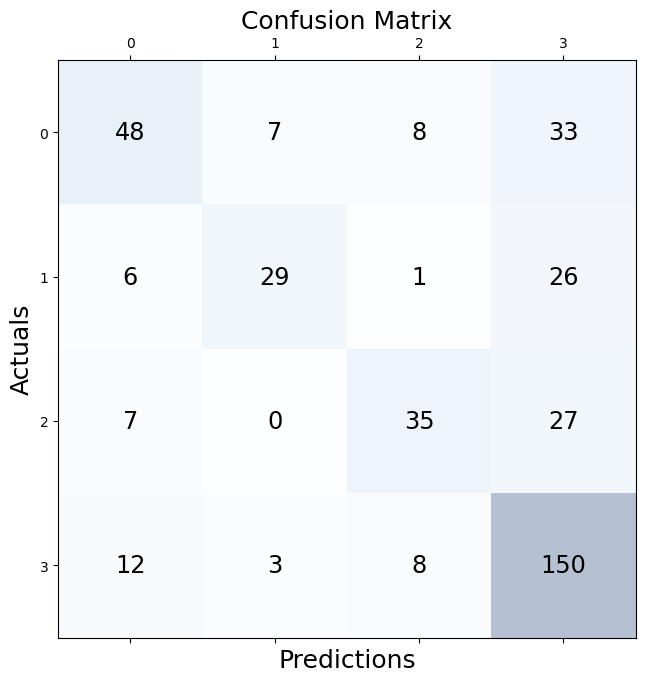

In [21]:
preds = model.predict(X_test)

print("acc: ", accuracy_score(y_test, preds))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()